# Data Migration: SQL Server to Postgres


In [272]:
import os
import pandas as pd
import pyodbc
import psycopg2
from psycopg2.extras import execute_values
from dotenv import load_dotenv

## 1. Load Credentials

In [273]:
load_dotenv()

True

In [274]:
sql_host = os.getenv("SQL_SERVER_HOST")
sql_db = os.getenv("SQL_SERVER_DATABASE")

In [275]:
print(f"SQL Server Host: {sql_host}")
print(f"SQL Server Database: {sql_db}")

SQL Server Host: DESKTOP-516QCDP\SQLEXPRESS
SQL Server Database: TransactionDB_UAT


In [276]:
pg_host = os.getenv("POSTGRES_HOST")
pg_db = os.getenv("POSTGRES_DATABASE")
pg_user = os.getenv("POSTGRES_USER")
pg_password = os.getenv("POSTGRES_PASSWORD")
pg_port = os.getenv("POSTGRES_PORT")  


In [277]:
print(f"POSTGRES Host: {pg_host}")
print(f"POSTGRES Database: {pg_db}")
print(f"POSTGRES User: {pg_user}")
print(f"POSTGRES Password: {pg_password}")
print(f"POSTGRES Port: {pg_port}")

POSTGRES Host: localhost
POSTGRES Database: Transaction_uat
POSTGRES User: postgres
POSTGRES Password: qwertyuiop
POSTGRES Port: 5432


## 2 Connect to SQL SERVER

In [278]:
print("Connecting to SQL Server...")
print(f"  Server: {sql_host}, Database: {sql_db}")

Connecting to SQL Server...
  Server: DESKTOP-516QCDP\SQLEXPRESS, Database: TransactionDB_UAT


In [279]:
try:
    sql_conn_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER=localhost,1433;"
        f"DATABASE={sql_db};"
        "Trusted_Connection=yes;"
        "TrustServerCertificate=yes;"
    )
    sql_conn = pyodbc.connect(sql_conn_string)
    sql_cursor = sql_conn.cursor()
    print("Successfully connected to SQL Server.")

except Exception as e:
    print("Error connecting to SQL Server:")
    print(e)
    print(""" How to Troubleshoot:
        > 1. Ensure that the SQL Server is running and accessible from your network.
        > 2. Check server name in .env file is correct.
        > 3. Check windows authentication permissions are enabled.
          ....
 """)


Successfully connected to SQL Server.


## 3. Connect to PostgreSQL


In [280]:
print("Connecting to Postgres...")
print(f"  Server: {pg_host}, Database: {pg_db}, User: {pg_user}")

Connecting to Postgres...
  Server: localhost, Database: Transaction_uat, User: postgres


In [281]:
try:
    pg_conn = psycopg2.connect(
        host=pg_host,
        port=pg_port,
        dbname=pg_db,
        user=pg_user,
        password=pg_password
    )
    pg_cursor = pg_conn.cursor()
    pg_cursor.execute("SELECT version();")

    pg_version = pg_cursor.fetchone()[0]
    print("Successfully connected to PostgreSQL.")
    print(f"PostgreSQL version: {pg_version[:50]}...\n")

except psycopg2.OperationalError as e:
    print(f"Error connecting to PostgreSQL: {e}")
    print(""" How to Troubleshoot:
        > 1. Ensure that the PostgreSQL server is running.
        > 2. Check connection parameters in the .env file.
        > 3. Ensure the user has access to the database.
        > 4. Ensure PostgreSQL is listening on the specified port.
    """)

except Exception as e:
    print(f"An unexpected error occurred while connecting to PostgreSQL: {e}")
    raise


Successfully connected to PostgreSQL.
PostgreSQL version: PostgreSQL 18.1 on x86_64-windows, compiled by msv...



## 4. Define the tables for Migration

### Migration Order

- Categories (no dependencies)
- Suppliers (no dependencies)
- Customers (no dependencies)
- Products (depends on Categories and Suppliers)

In [282]:
tables_to_migrate = ["Categories", "Suppliers", "Customers", "Products"]
print(tables_to_migrate)

['Categories', 'Suppliers', 'Customers', 'Products']


In [283]:
print("Table to migrate:")
for i, table in enumerate(tables_to_migrate, start=1):
    print(f"  {i}: {table}")

total_no_of_tables = len(tables_to_migrate)
print(f"Total number of tables to migrate: {total_no_of_tables}")

Table to migrate:
  1: Categories
  2: Suppliers
  3: Customers
  4: Products
Total number of tables to migrate: 4



## 5. Run pre-migration Checks

In [284]:
print("=" * 50)
print(">>> CHECK 1: ROW COUNT CHECKS <<<")
print("=" * 50)

>>> CHECK 1: ROW COUNT CHECKS <<<


In [285]:
baseline_row_counts = {}

try:
    for table in tables_to_migrate:

        row_count_query = f"""
        SELECT SUM(row_count)
        FROM sys.dm_db_partition_stats
        WHERE object_id = OBJECT_ID('{table}')
          AND index_id IN (0,1)
        """

        sql_cursor.execute(row_count_query)
        count = sql_cursor.fetchone()[0] or 0

        key = table.lower()
        baseline_row_counts[key] = count

        print(f"{table:15} : {count: >12} rows")

    total_rows = sum(baseline_row_counts.values())

    print("=" * 50)
    print(f"{'Total Rows to Migrate':<25} : {total_rows:>15,} rows")
    print("\n Baseline Captured! ")

except Exception as e:
    print(f"Baseline capture failed:{e}")
    raise


Categories      :            8 rows
Suppliers       :         5000 rows
Customers       :       900000 rows
Products        :       150000 rows
Total Rows to Migrate     :       1,055,008 rows

 Baseline Captured! 


In [286]:
sql_cursor.execute("""
    SELECT
        SCHEMA_NAME(schema_id) + '.' + name AS object_name,
        QUOTENAME(SCHEMA_NAME(schema_id)) + '.' + QUOTENAME(name) AS quoted_name
    FROM sys.tables
    WHERE is_ms_shipped = 0
""")

table_map = {
    row[0]: row[1]   # unquoted_name -> quoted_name
    for row in sql_cursor.fetchall()
}

tables_to_migrate = list(table_map.keys())




In [287]:
if not tables_to_migrate:
    raise RuntimeError("No user tables found in database.")

In [288]:
print("=" * 50)
print(">>> CHECK 2: NULL COUNTS (CustomerName) <<<")
print("=" * 50)

>>> CHECK 2: NULL COUNTS (CustomerName) <<<


In [289]:
quality_issues = []

try:
    print("\n=== STARTING DATA QUALITY CHECKS ===")

    # -------------------------------
    # CHECK 2: NULL Customer Names
    # -------------------------------
    print("\nCHECK 2: NULL Customer Names")

    sql_cursor.execute("""
        SELECT COUNT(*)
        FROM Customers
        WHERE CustomerName IS NULL
    """)

    null_names = sql_cursor.fetchone()[0]

    if null_names > 0:
        quality_issues.append(
            f"{null_names:,} customers with NULL names"
        )


    # -------------------------------
    # CHECK 3: Invalid Emails
    # -------------------------------
    print("\nCHECK 3: Invalid Email Formats")

    email_sql = """
        SELECT COUNT(*)
        FROM Customers
        WHERE Email IS NOT NULL
        AND (
            Email NOT LIKE '%_@_%._%'
            OR Email LIKE '%@invalid%'
            OR Email LIKE '% %'
            OR Email LIKE '%..%'
            OR Email LIKE '%.@%'
            OR Email LIKE '%@.%'
            OR Email LIKE '@%'
            OR Email LIKE '%.'
        )
    """

    sql_cursor.execute(email_sql)

    invalid_emails = sql_cursor.fetchone()[0]

    if invalid_emails > 0:
        quality_issues.append(
            f"{invalid_emails:,} customers with invalid email formats"
        )


    # -------------------------------
    # CHECK 4: Negative Prices
    # -------------------------------
    print("\nCHECK 4: Negative Product Prices")

    sql_cursor.execute("""
        SELECT COUNT(*)
        FROM Products
        WHERE UnitPrice < 0
    """)

    negative_prices = sql_cursor.fetchone()[0]

    if negative_prices > 0:
        quality_issues.append(
            f"{negative_prices:,} prices with negative prices"
        )


    # -------------------------------
    # CHECK 5: Negative Stock
    # -------------------------------
    print("\nCHECK 5: Negative Stock Quantities")

    sql_cursor.execute("""
        SELECT COUNT(*)
        FROM Products
        WHERE StockQuantity < 0
    """)

    negative_stock = sql_cursor.fetchone()[0]

    if negative_stock > 0:
        quality_issues.append(
            f"{negative_stock:,} products with negative stock quantities"
        )


    # -------------------------------
    # CHECK 6: Orphaned Foreign Keys
    # -------------------------------
    print("\nCHECK 6: Orphaned Supplier References")

    sql_cursor.execute("""
        SELECT COUNT(*)
        FROM Products prod
        WHERE NOT EXISTS (
            SELECT 1
            FROM Suppliers sup
            WHERE sup.SupplierID = prod.SupplierID
        )
    """)

    orphaned_fks = sql_cursor.fetchone()[0]

    if orphaned_fks > 0:
        quality_issues.append(
            f"{orphaned_fks:,} products with orphaned supplier IDs"
        )

    # -------------------------------
    # CHECK 7: Future-Dated Records
    # -------------------------------
    print("\nCHECK 7: Future-Dated Customer Records")

    sql_cursor.execute("""
        SELECT COUNT(*)
        FROM Customers
        WHERE CreatedDate > GETDATE()
    """)

    future_dates = sql_cursor.fetchone()[0]

    if future_dates > 0:
        quality_issues.append(
            f"{future_dates:,} customers with future-dated CreatedDate values"
        )



    # -------------------------------
    # FINAL REPORT
    # -------------------------------
    print("\n=== DATA QUALITY REPORT ===")

    if not quality_issues:
        print("No data quality issues found.")
    else:
        print("Data quality issues detected (Will Migrate as is):")
        for issue in quality_issues:
            print(f"- {issue}")


except Exception as e:
    print("Data quality check failed:")
    print(e)



=== STARTING DATA QUALITY CHECKS ===

CHECK 2: NULL Customer Names

CHECK 3: Invalid Email Formats

CHECK 4: Negative Product Prices

CHECK 5: Negative Stock Quantities

CHECK 6: Orphaned Supplier References

CHECK 7: Future-Dated Customer Records

=== DATA QUALITY REPORT ===
Data quality issues detected (Will Migrate as is):
- 4,514 customers with NULL names
- 27,318 customers with invalid email formats
- 775 prices with negative prices
- 1,467 products with negative stock quantities
- 24,700 products with orphaned supplier IDs
- 2,731 customers with future-dated CreatedDate values


## 6. Get Table Schema

In [290]:
print("=" * 50)
print(">>> ANALYZE TABLE SCHEMA <<<")
print("=" * 50)

>>> ANALYZE TABLE SCHEMA <<<


In [291]:
table_schema = {}

try:
    for table in tables_to_migrate:

        clean_table = table.split(".")[-1]

        schema_query = f"""
            SELECT
                COLUMN_NAME,
                DATA_TYPE,
                CHARACTER_MAXIMUM_LENGTH,
                IS_NULLABLE
            FROM INFORMATION_SCHEMA.COLUMNS
            WHERE TABLE_NAME = '{clean_table}'
              AND TABLE_SCHEMA = 'dbo'
            ORDER BY ORDINAL_POSITION
        """

        schema_df = pd.read_sql(schema_query, sql_conn)

        if schema_df.empty:
            print(f"Warning: No schema found for {clean_table}")
        else:
            table_schema[clean_table] = schema_df
            print(f"Loaded schema for: {clean_table}")

except Exception as e:
    print("Schema extraction failed:")
    print(e)


C:\Users\Daniel\AppData\Local\Temp\ipykernel_31936\1417242039.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schema_df = pd.read_sql(schema_query, sql_conn)


Loaded schema for: Categories
Loaded schema for: Suppliers
Loaded schema for: Customers
Loaded schema for: Products


## 7. Define Data Type Mappings

In [292]:
print("=" * 50)
print(">>> DATA TYPE MAPPING <<<")
print("=" * 50)

>>> DATA TYPE MAPPING <<<


In [293]:
type_mapping = {
    "int": "INTEGER",
    "bigint": "BIGINT",
    "smallint": "SMALLINT",
    "tinyint": "SMALLINT",
    "bit": "BOOLEAN",
    "decimal": "NUMERIC",
    "numeric": "NUMERIC",   
    "money": "NUMERIC(19,4)",
    "smallmoney": "NUMERIC(10,4)",
    "float": "DOUBLE PRECISION",
    "real": "REAL",
    "datetime": "TIMESTAMP",
    "datetime2": "TIMESTAMP",
    "smalldatetime": "TIMESTAMP",
    "date": "DATE",
    "time": "TIME",
    "char": "CHAR",
    "varchar": "VARCHAR",
    "nchar": "CHAR",    
    "nvarchar": "VARCHAR",  
    "text": "TEXT",
    "ntext": "TEXT"
}

In [294]:
print("SQL Server to Postgres Data Type Mapping:")
print()

for sql_type, pg_type in list(type_mapping.items()):
    print(f"  {sql_type:<17} -->    {pg_type}")

SQL Server to Postgres Data Type Mapping:

  int               -->    INTEGER
  bigint            -->    BIGINT
  smallint          -->    SMALLINT
  tinyint           -->    SMALLINT
  bit               -->    BOOLEAN
  decimal           -->    NUMERIC
  numeric           -->    NUMERIC
  money             -->    NUMERIC(19,4)
  smallmoney        -->    NUMERIC(10,4)
  float             -->    DOUBLE PRECISION
  real              -->    REAL
  datetime          -->    TIMESTAMP
  datetime2         -->    TIMESTAMP
  smalldatetime     -->    TIMESTAMP
  date              -->    DATE
  time              -->    TIME
  char              -->    CHAR
  varchar           -->    VARCHAR
  nchar             -->    CHAR
  nvarchar          -->    VARCHAR
  text              -->    TEXT
  ntext             -->    TEXT


## 8. Create tables In PostgreSQL

In [295]:
print("=" * 50)
print(">>> CREATE TABLES IN POSTGRES <<<")
print("=" * 50)

>>> CREATE TABLES IN POSTGRES <<<


In [296]:
try:
    for table in tables_to_migrate:

        # Remove dbo. prefix
        clean_table = table.replace("dbo.", "")

        schema = table_schema[clean_table]

        pg_table = clean_table.lower()

        pg_cursor.execute(f"DROP TABLE IF EXISTS {pg_table} CASCADE;")

        column_definitions = []

        for idx, row in schema.iterrows():

            col_name = row["COLUMN_NAME"].lower()
            sql_type = row["DATA_TYPE"]
            is_nullable = row["IS_NULLABLE"]

            base_type = sql_type.lower()
            pg_type = type_mapping.get(base_type, "TEXT")

            condition_1 = idx == 0
            condition_2 = col_name.endswith("id")
            condition_3 = "int" in base_type

            if condition_1 and condition_2 and condition_3:
                column_definitions.append(
                    f"{col_name} SERIAL PRIMARY KEY"
                )
            else:
                col_def = f"{col_name} {pg_type}"

                if is_nullable == "NO":
                    col_def += " NOT NULL"

                column_definitions.append(col_def)


        column_string = ",\n      ".join(column_definitions)

        create_query = f"""
        CREATE TABLE {pg_table} (
              {column_string}
        );
        """

        pg_cursor.execute(create_query)
        pg_conn.commit()

        print(f"[SUCCESS] Created table: {pg_table}")


except psycopg2.Error as e:
    print(f"Postgres experienced an error while creating a table: {e}")
    pg_conn.rollback()
    raise

except Exception as e:
    print(f"Error creating tables in Postgres: {e}")


[SUCCESS] Created table: categories
[SUCCESS] Created table: suppliers
[SUCCESS] Created table: customers
[SUCCESS] Created table: products


### Testing Migration

In [297]:
print("=" * 50)
print(">>> TESTING MIGRATION (SINGLE TABLE) <<<")
print("=" * 50)

>>> TESTING MIGRATION (SINGLE TABLE) <<<


In [298]:
test_table = 'customers'  # Change this to test different tables
pg_table = test_table.lower()

In [299]:
try:
    print("1. Reading data from SQL Server...")

    source_table = test_table.split(".")[-1]
    pg_table = source_table.lower()

    extract_query = f"SELECT * FROM {test_table}"
    test_df = pd.read_sql(extract_query, sql_conn)

    print(f"        Retrieved {len(test_df):,} rows from {test_table}.")

    print("2. Transforming data types...")

    for col in test_df.columns:
        if col.lower() == "isactive":
            test_df[col] = test_df[col].astype(bool)
            print("[SUCCESS] Converted IsActive to boolean.")

    print("3. Preparing data for loading...")

    columns = [col.lower() for col in test_df.columns]
    columns_string = ", ".join(columns)

    data_tuples = [tuple(row) for row in test_df.to_numpy()]

    print(f"        Prepared {len(data_tuples):,} rows.")

    print("4. Clearing existing data (safety)...")

    pg_cursor.execute(f"TRUNCATE TABLE {pg_table} RESTART IDENTITY CASCADE;")
    pg_conn.commit()

    print("5. Loading data into Postgres...")

    insert_query = f"""
        INSERT INTO {pg_table} ({columns_string})
        VALUES %s
    """

    execute_values(pg_cursor, insert_query, data_tuples, page_size=1000)
    pg_conn.commit()

    print(f"[SUCCESS] Loaded {len(data_tuples):,} rows into {pg_table}.")

    print("6. Verifying row counts...")

    pg_cursor.execute(f"SELECT COUNT(*) FROM {pg_table}")
    pg_count = pg_cursor.fetchone()[0]

    baseline_key = source_table

    if baseline_key in baseline_row_counts:
        sql_count = baseline_row_counts[baseline_key]

        if pg_count == sql_count:
            print(f"[SUCCESS] Row count matches: {pg_count:,} == {sql_count:,}")
        else:
            print(f"[ERROR] Row count mismatch: {pg_count:,} != {sql_count:,}")
    else:
        print(f"[WARNING] No baseline found for {baseline_key}")

    print(f"\nMigration for table '{test_table}' completed successfully.")
    print("=" * 60)

except Exception as e:
    pg_conn.rollback()
    print("\nMigration failed:")
    print(e)
    raise


1. Reading data from SQL Server...


C:\Users\Daniel\AppData\Local\Temp\ipykernel_31936\3024234870.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_df = pd.read_sql(extract_query, sql_conn)


        Retrieved 900,000 rows from customers.
2. Transforming data types...
[SUCCESS] Converted IsActive to boolean.
3. Preparing data for loading...
        Prepared 900,000 rows.
4. Clearing existing data (safety)...
5. Loading data into Postgres...
[SUCCESS] Loaded 900,000 rows into customers.
6. Verifying row counts...
[SUCCESS] Row count matches: 900,000 == 900,000

Migration for table 'customers' completed successfully.


## 10. Migrating rremaining tables

In [300]:
print("=" * 50)
print(">>> MIGRATING REMAINING TABLES <<<")
print("=" * 50)

>>> MIGRATING REMAINING TABLES <<<


In [301]:
remaining_tables = [
    t for t in tables_to_migrate
    if t.split(".")[-1].lower() != "customers"
]


for table in remaining_tables:

    clean_table = table.split(".")[-1]
    pg_table = clean_table.lower()

    print(f"Migrating table: {table}  --->  {pg_table}")

    try:
        print("1. Reading data from SQL Server...")

        extract_query = f"SELECT * FROM {table}"
        sql_df = pd.read_sql(extract_query, sql_conn)

        print(f"        Retrieved {len(sql_df):,} rows from {table}.")


        print("2. Preparing data types...")

        data_tuples = [tuple(row) for row in sql_df.to_numpy()]
        columns = [col.lower() for col in sql_df.columns]

        column_string = ", ".join(columns)

        insert_query = f"""
            INSERT INTO {pg_table} ({column_string})
            VALUES %s
        """

        print(f"       Prepared {len(data_tuples):,} rows for insertion.\n")


        print("3. Clearing existing data...")

        pg_cursor.execute(
            f"TRUNCATE TABLE {pg_table} RESTART IDENTITY CASCADE;"
        )
        pg_conn.commit()


        print("4. Processing bulk load...")

        execute_values(
            pg_cursor,
            insert_query,
            data_tuples,
            page_size=1000
        )

        pg_conn.commit()

        print(f"[SUCCESS] ------> Loaded {len(data_tuples):,} rows into {pg_table}.\n")


        print("5. Verifying row counts...")

        pg_cursor.execute(f"SELECT COUNT(*) FROM {pg_table}")
        pg_count = pg_cursor.fetchone()[0]


        baseline_key = clean_table.lower()

        sql_count = baseline_row_counts.get(baseline_key)


        if sql_count is None:
            print(f"[WARNING] No baseline found for {baseline_key}\n")

        elif pg_count == sql_count:
            print(f"[SUCCESS] -----> Verification passed: {pg_count:,} == {sql_count:,}\n")

        else:
            print(f"[ERROR] ------> Count mismatch: {pg_count:,} != {sql_count:,}\n")


        print(f"Migration for table '{table}' completed successfully.")


    except Exception as e:

        pg_conn.rollback()

        print(f"\nMigration failed for table '{table}':")
        print(e)

        raise


Migrating table: dbo.Categories  --->  categories
1. Reading data from SQL Server...
        Retrieved 8 rows from dbo.Categories.
2. Preparing data types...
       Prepared 8 rows for insertion.


C:\Users\Daniel\AppData\Local\Temp\ipykernel_31936\3617544266.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_df = pd.read_sql(extract_query, sql_conn)



3. Clearing existing data...
4. Processing bulk load...
[SUCCESS] ------> Loaded 8 rows into categories.

5. Verifying row counts...
[SUCCESS] -----> Verification passed: 8 == 8

Migration for table 'dbo.Categories' completed successfully.
Migrating table: dbo.Suppliers  --->  suppliers
1. Reading data from SQL Server...
        Retrieved 5,000 rows from dbo.Suppliers.
2. Preparing data types...
       Prepared 5,000 rows for insertion.

3. Clearing existing data...
4. Processing bulk load...
[SUCCESS] ------> Loaded 5,000 rows into suppliers.

5. Verifying row counts...
[SUCCESS] -----> Verification passed: 5,000 == 5,000

Migration for table 'dbo.Suppliers' completed successfully.
Migrating table: dbo.Products  --->  products
1. Reading data from SQL Server...
        Retrieved 150,000 rows from dbo.Products.
2. Preparing data types...
       Prepared 150,000 rows for insertion.

3. Clearing existing data...
4. Processing bulk load...
[SUCCESS] ------> Loaded 150,000 rows into produ

## 11. Run post-migration validation

### 1. Row count in postgres

##### SUCCESS: MATCHES SQL SERVER

### 2. Data type checks

##### SUCCESS: MATCHES SQL SERVER

### 3. Primary Key checks (duplicates)

##### SUCCESS: MATCHES SQL SERVER

### 4. Referential integrity checks 

##### SUCCESS: MATCHES SQL SERVER.


In [302]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

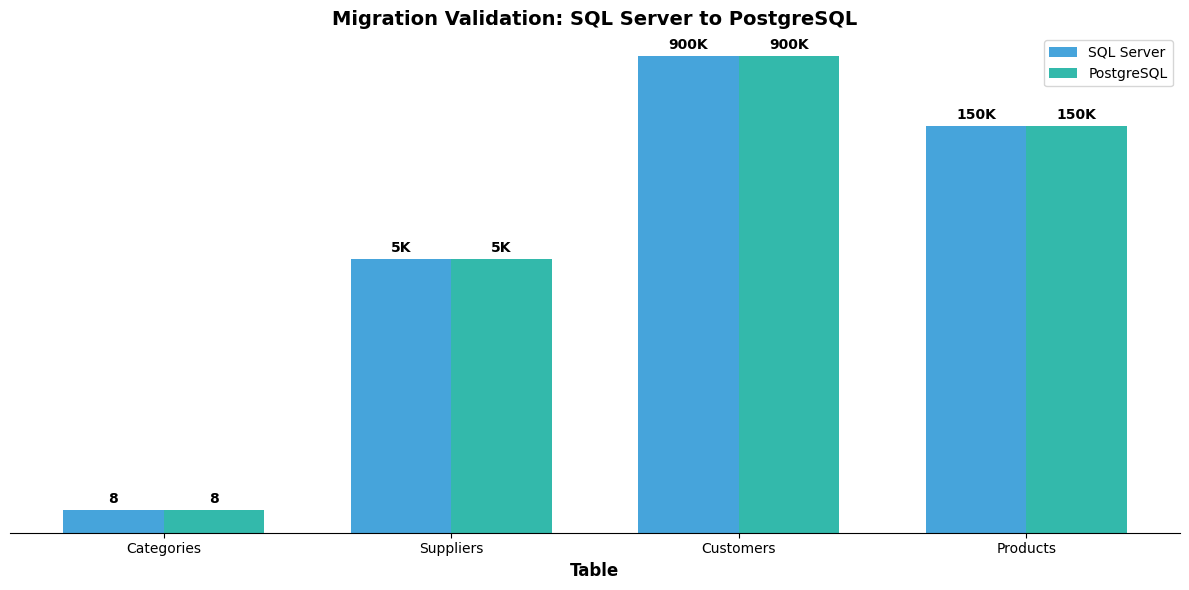

In [324]:
fig, ax = plt.subplots(figsize=(12, 6))

table_names = tables_to_migrate
sql_counts = [baseline_row_counts.get(t.split(".")[-1].lower(), 0) for t in tables_to_migrate]

pg_counts = []
for table in tables_to_migrate:
    pg_cursor.execute(f"SELECT COUNT(*) FROM {table.split('.')[-1].lower()}")
    pg_counts.append(pg_cursor.fetchone()[0])


x = range(len(table_names))
width = 0.35

bars1 = ax.bar(
            [i - width/2 for i in x],
            sql_counts,
            width,
            label='SQL Server',
            color="#188ED3",
            alpha=0.8
)

bars2 = ax.bar(
            [i + width/2 for i in x],
            pg_counts,
            width,
            label='PostgreSQL',
            color="#00A896",
            alpha=0.8
)


ax.set_xlabel('Table', fontweight='bold', fontsize=12)

ax.set_title('Migration Validation: SQL Server to PostgreSQL', fontweight='bold', fontsize=14)

ax.set_xticks(x)
ax.set_xticklabels([t.split(".")[-1] for t in table_names])

ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yscale('log')
ax.legend()

for bars in  [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        label = f"{int(height/1000):,}K" if height >= 1000 else f"{int(height)}"

        ax.text(bar.get_x() + bar.get_width()/2, 
                height * 1.1, 
                label,
                ha ='center', 
                va ='bottom', 
                fontsize = 10,
                fontweight='bold')

plt.tight_layout()
plt.show()
